In [1]:
import pandas as pd
import requests
import json
from pathlib import Path
import re
from datetime import date
import time
import os
from fastai.tabular import *
import matplotlib.pyplot as plt

In [2]:
import torch

In [3]:
torch.cuda.device(0)

In [4]:
torch.cuda.get_device_name(0)

'GeForce RTX 2080'

In [5]:
with open(r'data/wiki_item_names') as f:
    item_names = f.readlines()
    cleaned_item_names = [name.strip() for name in item_names]

In [6]:
# cleaned_item_names

In [7]:
def get_item_df(item_name, sleppy_time=1):
    base_url = r"https://oldschool.runescape.wiki/api.php?action=query&prop=revisions&rvprop=content&format=json&titles=Module%3AExchange%2F"
    postfix_url = r"%2FData"
    full_url = f'{base_url}{item_name}{postfix_url}'
    resp = requests.get(full_url)
    jsond = resp.json()
    try:
        regex_text = jsond['query']['pages'][next(iter(jsond['query']['pages'].keys()))]['revisions'][0]['*']
        m = re.findall(r'[\d]+:[\d]+', regex_text)
        item_df = pd.DataFrame()
        item_df['dt'] = [int(string.split(':')[0]) for string in m]
        item_df[f'{item_name} price'] = [int(string.split(':')[1]) for string in m]
        item_df['date_obj'] = item_df['dt'].apply(lambda x: date.fromtimestamp(x))
        item_df.set_index('date_obj', inplace=True)
        item_df = item_df.drop('dt', axis=1)
        time.sleep(sleppy_time)
        return item_df
    except:
        pass

In [6]:
def retrieve_dfs(xslice = True):
    if xslice:
        item_dfs = [get_item_df(item_name,1) for item_name in cleaned_item_names[40:45]]
    else:
        item_dfs = [get_item_df(item_name,1) for item_name in cleaned_item_names]
    return item_dfs

In [65]:
# item_dfs = retrieve_dfs(False)

In [8]:
item_dfs

NameError: name 'item_dfs' is not defined

In [79]:
def save_dfs(item_dfs):
    for df in item_dfs:
        try:
            df.to_csv(f'./data/wiki_prices/{df.columns[0]}.csv')
        except:
            pass

In [80]:
# save_dfs(item_dfs)

In [9]:
def load_dfs():
    item_dfs = []
    for name in list(os.walk('./data/wiki_prices'))[0][2]:
        df = pd.read_csv(f'./data/wiki_prices/{name}')
        df = df.set_index(df.columns[0])
        item_dfs.append(df)
    return item_dfs

In [10]:

item_dfs = load_dfs()

In [11]:
item_dfs

[            3rd%20age%20amulet price
 date_obj                            
 2015-03-26                   8135122
 2015-03-27                   8135122
 2015-03-28                   8135122
 2015-03-29                   8135122
 2015-03-30                   8135122
 ...                              ...
 2020-05-09                  21895776
 2020-05-10                  21895776
 2020-05-11                  21895776
 2020-05-12                  22812427
 2020-05-13                  22812427
 
 [1826 rows x 1 columns],
             3rd%20age%20axe price
 date_obj                         
 2016-07-06              300000000
 2016-07-07              300000000
 2016-07-08              300000000
 2016-07-09              300000000
 2016-07-10              310633064
 ...                           ...
 2020-05-09              244161866
 2020-05-10              244161866
 2020-05-11              244161866
 2020-05-12              244161866
 2020-05-13              244161866
 
 [1364 rows x 1 colum

In [12]:
df_dict = {}

In [13]:
for df in item_dfs:
    try:
        df_dict[df.columns[0]] = df
    except:
        pass

In [14]:
df_dict

{'3rd%20age%20amulet price':             3rd%20age%20amulet price
 date_obj                            
 2015-03-26                   8135122
 2015-03-27                   8135122
 2015-03-28                   8135122
 2015-03-29                   8135122
 2015-03-30                   8135122
 ...                              ...
 2020-05-09                  21895776
 2020-05-10                  21895776
 2020-05-11                  21895776
 2020-05-12                  22812427
 2020-05-13                  22812427
 
 [1826 rows x 1 columns],
 '3rd%20age%20axe price':             3rd%20age%20axe price
 date_obj                         
 2016-07-06              300000000
 2016-07-07              300000000
 2016-07-08              300000000
 2016-07-09              300000000
 2016-07-10              310633064
 ...                           ...
 2020-05-09              244161866
 2020-05-10              244161866
 2020-05-11              244161866
 2020-05-12              244161866
 2020

In [15]:
item_name = 'Bandos%20godsword price'

In [16]:
item_df_training = df_dict[item_name]

In [17]:
item_df_training[item_name]

date_obj
2015-03-26     3188120
2015-03-27     3188120
2015-03-28     3153641
2015-03-29     3168120
2015-03-30     3145239
                ...   
2020-05-09    13245757
2020-05-10    13231731
2020-05-11    13181398
2020-05-12    13157501
2020-05-13    13106793
Name: Bandos%20godsword price, Length: 1820, dtype: int64

In [18]:
for i in range(90):
    item_df_training[f'{item_name} {i} days ago'] = item_df_training[item_name].shift(i)

In [19]:
rolling_averages = [3,7,14,21,30,60,90]

In [20]:
for rolling_average in rolling_averages:
    item_df_training[f'{item_name} {rolling_average} day rolling average'] = item_df_training[item_name].rolling(rolling_average).mean()

In [21]:
for rolling_average in rolling_averages:
    item_df_training[f'{item_name} delta {rolling_average} day rolling average'] = item_df_training[item_name] - item_df_training[f'{item_name} {rolling_average} day rolling average']

In [22]:
item_df_training['Y'] = item_df_training[item_name].shift(-7)

In [221]:
scaling_factor = item_df_training['Y'].mean()
scaling_factor

6756458.168229454

In [222]:
item_df_training['Y'] /= scaling_factor

In [223]:
item_df_training.tail(10)

,Bandos%20godsword price,Bandos%20godsword price 0 days ago,Bandos%20godsword price 1 days ago,Bandos%20godsword price 2 days ago,Bandos%20godsword price 3 days ago,Bandos%20godsword price 4 days ago,Bandos%20godsword price 5 days ago,Bandos%20godsword price 6 days ago,Bandos%20godsword price 7 days ago,Bandos%20godsword price 8 days ago,...,Bandos%20godsword price 60 day rolling average,Bandos%20godsword price 90 day rolling average,Bandos%20godsword price delta 3 day rolling average,Bandos%20godsword price delta 7 day rolling average,Bandos%20godsword price delta 14 day rolling average,Bandos%20godsword price delta 21 day rolling average,Bandos%20godsword price delta 30 day rolling average,Bandos%20godsword price delta 60 day rolling average,Bandos%20godsword price delta 90 day rolling average,Y
date_obj,,,,,,,,,,,,,,,,,,,,,
2020-05-04,13072641,13072641,13301814.0,13002689.0,12596802.0,12448948.0,12233017.0,12157931.0,12221711.0,12293453.0,...,1.175102e+07,1.119806e+07,-53073.666667,384949.285714,495393.642857,270380.238095,220092.266667,1.321617e+06,1.874585e+06,1.950933
2020-05-05,13045429,13045429,13072641.0,13301814.0,13002689.0,12596802.0,12448948.0,12233017.0,12157931.0,12221711.0,...,1.179276e+07,1.121083e+07,-94532.333333,230951.857143,458308.357143,260135.571429,179595.233333,1.252667e+06,1.834595e+06,1.947396
2020-05-06,12993210,12993210,13045429.0,13072641.0,13301814.0,13002689.0,12596802.0,12448948.0,12233017.0,12157931.0,...,1.183434e+07,1.122899e+07,-43883.333333,70133.857143,384932.071429,224933.857143,117255.433333,1.158868e+06,1.764216e+06,1.939891
2020-05-07,13054803,13054803,12993210.0,13045429.0,13072641.0,13301814.0,13002689.0,12596802.0,12448948.0,12233017.0,...,1.187768e+07,1.125412e+07,23655.666667,45176.142857,404279.785714,298594.904762,167275.166667,1.177128e+06,1.800680e+06,NaN
2020-05-08,13273304,13273304,13054803.0,12993210.0,13045429.0,13072641.0,13301814.0,13002689.0,12596802.0,12448948.0,...,1.192643e+07,1.128612e+07,166198.333333,167034.000000,557060.785714,517163.523810,367226.900000,1.346878e+06,1.987181e+06,NaN
2020-05-09,13245757,13245757,13273304.0,13054803.0,12993210.0,13045429.0,13072641.0,13301814.0,13002689.0,12596802.0,...,1.197713e+07,1.132152e+07,54469.000000,104763.000000,464220.642857,489470.190476,326980.866667,1.268631e+06,1.924239e+06,NaN
2020-05-10,13231731,13231731,13245757.0,13273304.0,13054803.0,12993210.0,13045429.0,13072641.0,13301814.0,13002689.0,...,1.202852e+07,1.135852e+07,-18533.000000,100748.857143,383174.785714,472138.523810,305032.066667,1.203210e+06,1.873210e+06,NaN
2020-05-11,13181398,13181398,13231731.0,13245757.0,13273304.0,13054803.0,12993210.0,13045429.0,13072641.0,13301814.0,...,1.208148e+07,1.139691e+07,-38230.666667,34879.142857,264292.714286,414393.476190,259713.233333,1.099913e+06,1.784488e+06,NaN
2020-05-12,13157501,13157501,13181398.0,13231731.0,13245757.0,13273304.0,13054803.0,12993210.0,13045429.0,13072641.0,...,1.213475e+07,1.143593e+07,-32709.000000,-5028.142857,168997.857143,378577.523810,242371.933333,1.022749e+06,1.721573e+06,NaN


In [334]:
item_df_training.tail(10)['Y'] * scaling_factor

date_obj
2020-05-04    13181398.0
2020-05-05    13157501.0
2020-05-06    13106793.0
2020-05-07           NaN
2020-05-08           NaN
2020-05-09           NaN
2020-05-10           NaN
2020-05-11           NaN
2020-05-12           NaN
2020-05-13           NaN
Name: Y, dtype: float64

In [224]:
item_df_training.shape

(1820, 106)

In [225]:
#replace drop 

In [226]:
trimmed_df = item_df_training.dropna(how='any')

In [227]:
trimmed_df.shape

(1724, 106)

In [228]:
# train = trimmed_df[0:int(trimmed_df.shape[0]*.8)]

In [229]:
# test = trimmed_df[int(trimmed_df.shape[0]*.8):0]

In [230]:
# train.shape

In [231]:
procs = [Normalize]

In [232]:
valid_idx = range(int(len(df)*.8), len(df)-60)

In [233]:
dep_var = 'Y'

In [234]:
path = Path(f'./data/wiki_urls/{item_name}')

In [235]:
trimmed_df['date_obj'] = trimmed_df.index

C:\Users\adamh\anaconda3\envs\catstack\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [236]:
trimmed_df['date_obj'] = trimmed_df['date_obj'].apply(lambda x: pd.to_datetime(x))

C:\Users\adamh\anaconda3\envs\catstack\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [237]:
time_trimmed_df = trimmed_df.loc[trimmed_df['date_obj'] > pd.to_datetime('2018-05-01')]

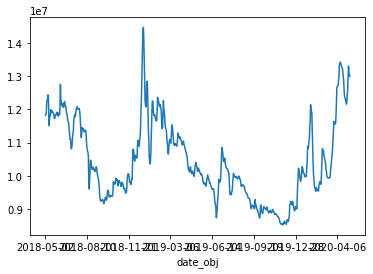

In [238]:
time_trimmed_df[item_name].plot()

In [239]:
time_trimmed_df = time_trimmed_df.drop(columns=['date_obj'], axis=1)

In [240]:
trimmed_df = time_trimmed_df

In [242]:
df = trimmed_df

In [243]:
df

,Bandos%20godsword price,Bandos%20godsword price 0 days ago,Bandos%20godsword price 1 days ago,Bandos%20godsword price 2 days ago,Bandos%20godsword price 3 days ago,Bandos%20godsword price 4 days ago,Bandos%20godsword price 5 days ago,Bandos%20godsword price 6 days ago,Bandos%20godsword price 7 days ago,Bandos%20godsword price 8 days ago,...,Bandos%20godsword price 90 day rolling average,Bandos%20godsword price delta 3 day rolling average,Bandos%20godsword price delta 7 day rolling average,Bandos%20godsword price delta 14 day rolling average,Bandos%20godsword price delta 21 day rolling average,Bandos%20godsword price delta 30 day rolling average,Bandos%20godsword price delta 60 day rolling average,Bandos%20godsword price delta 90 day rolling average,Y,constant
date_obj,,,,,,,,,,,,,,,,,,,,,
2018-05-02,11818921,11818921,11824975.0,11809626.0,11763526.0,11723372.0,11768472.0,11789538.0,11762433.0,11979415.0,...,1.064563e+07,1080.333333,33431.000000,6134.928571,324676.238095,411576.800000,7.724445e+05,1.173295e+06,1.839836,1.045314e+07
2018-05-03,11859656,11859656,11818921.0,11824975.0,11809626.0,11763526.0,11723372.0,11768472.0,11789538.0,11762433.0,...,1.066813e+07,25138.666667,64149.142857,9825.571429,303201.666667,439997.466667,7.908224e+05,1.191529e+06,1.771420,1.045314e+07
2018-05-04,11877211,11877211,11859656.0,11818921.0,11824975.0,11809626.0,11763526.0,11723372.0,11768472.0,11789538.0,...,1.069626e+07,25281.666667,66170.000000,11199.714286,263918.952381,449548.700000,7.899552e+05,1.180955e+06,1.703742,1.045314e+07
2018-05-05,12167279,12167279,11877211.0,11859656.0,11818921.0,11824975.0,11809626.0,11763526.0,11723372.0,11768472.0,...,1.072446e+07,199230.333333,292822.714286,280416.785714,492025.523810,719317.933333,1.059780e+06,1.442817e+06,1.749774,1.045314e+07
2018-05-06,12273432,12273432,12167279.0,11877211.0,11859656.0,11818921.0,11824975.0,11809626.0,11763526.0,11723372.0,...,1.075523e+07,167458.000000,326132.000000,370517.142857,538407.571429,793710.766667,1.146492e+06,1.518205e+06,1.745821,1.045314e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-02,13002689,13002689,12596802.0,12448948.0,12233017.0,12157931.0,12221711.0,12293453.0,12331653.0,12353224.0,...,1.117125e+07,319876.000000,580610.285714,438755.785714,181238.714286,227421.100000,1.335072e+06,1.831439e+06,1.960459,1.045314e+07
2020-05-03,13301814,13301814,13002689.0,12596802.0,12448948.0,12233017.0,12157931.0,12221711.0,12293453.0,12331653.0,...,1.118567e+07,334712.333333,735683.714286,727916.357143,482856.952381,476659.733333,1.591642e+06,2.116142e+06,1.958383,1.045314e+07
2020-05-04,13072641,13072641,13301814.0,13002689.0,12596802.0,12448948.0,12233017.0,12157931.0,12221711.0,12293453.0,...,1.119806e+07,-53073.666667,384949.285714,495393.642857,270380.238095,220092.266667,1.321617e+06,1.874585e+06,1.950933,1.045314e+07


In [244]:
data = TabularDataBunch.from_df(path, df, dep_var, valid_idx=valid_idx, procs=procs, cat_names=[])

In [245]:
learn = tabular_learner(data, layers=[500,100], emb_szs={'native-country': 10}, metrics=mean_squared_error)

In [246]:
data.show_batch()

Bandos%20godsword price 85 days ago,Bandos%20godsword price 48 days ago,Bandos%20godsword price 61 days ago,constant,Bandos%20godsword price 64 days ago,Bandos%20godsword price 90 day rolling average,Bandos%20godsword price 24 days ago,Bandos%20godsword price,Bandos%20godsword price 74 days ago,Bandos%20godsword price 2 days ago,Bandos%20godsword price 73 days ago,Bandos%20godsword price 72 days ago,Bandos%20godsword price delta 21 day rolling average,Bandos%20godsword price 6 days ago,Bandos%20godsword price 63 days ago,Bandos%20godsword price 66 days ago,Bandos%20godsword price 14 days ago,Bandos%20godsword price 80 days ago,Bandos%20godsword price 59 days ago,Bandos%20godsword price delta 7 day rolling average,Bandos%20godsword price 70 days ago,Bandos%20godsword price 25 days ago,Bandos%20godsword price 5 days ago,Bandos%20godsword price 1 days ago,Bandos%20godsword price 27 days ago,Bandos%20godsword price 46 days ago,Bandos%20godsword price 8 days ago,Bandos%20godsword price 81 days ago,Bandos%20godsword price 30 day rolling average,Bandos%20godsword price 40 days ago,Bandos%20godsword price 17 days ago,Bandos%20godsword price delta 90 day rolling average,Bandos%20godsword price 84 days ago,Bandos%20godsword price 76 days ago,Bandos%20godsword price 79 days ago,Bandos%20godsword price 42 days ago,Bandos%20godsword price 30 days ago,Bandos%20godsword price 43 days ago,Bandos%20godsword price 65 days ago,Bandos%20godsword price 20 days ago,Bandos%20godsword price 13 days ago,Bandos%20godsword price 44 days ago,Bandos%20godsword price 83 days ago,Bandos%20godsword price 89 days ago,Bandos%20godsword price 34 days ago,Bandos%20godsword price delta 60 day rolling average,Bandos%20godsword price 0 days ago,Bandos%20godsword price 52 days ago,Bandos%20godsword price 7 days ago,Bandos%20godsword price 45 days ago,Bandos%20godsword price 50 days ago,Bandos%20godsword price 55 days ago,Bandos%20godsword price 39 days ago,Bandos%20godsword price 58 days ago,Bandos%20godsword price 41 days ago,Bandos%20godsword price 53 days ago,Bandos%20godsword price 18 days ago,Bandos%20godsword price 11 days ago,Bandos%20godsword price 60 days ago,Bandos%20godsword price 19 days ago,Bandos%20godsword price 68 days ago,Bandos%20godsword price 21 days ago,Bandos%20godsword price 3 days ago,Bandos%20godsword price 23 days ago,Bandos%20godsword price 10 days ago,Bandos%20godsword price 36 days ago,Bandos%20godsword price 21 day rolling average,Bandos%20godsword price 62 days ago,Bandos%20godsword price 67 days ago,Bandos%20godsword price 31 days ago,Bandos%20godsword price 26 days ago,Bandos%20godsword price 37 days ago,Bandos%20godsword price 82 days ago,Bandos%20godsword price 60 day rolling average,Bandos%20godsword price 35 days ago,Bandos%20godsword price 88 days ago,Bandos%20godsword price 28 days ago,Bandos%20godsword price 29 days ago,Bandos%20godsword price 38 days ago,Bandos%20godsword price 56 days ago,Bandos%20godsword price 12 days ago,Bandos%20godsword price 77 days ago,Bandos%20godsword price 16 days ago,Bandos%20godsword price 87 days ago,Bandos%20godsword price 4 days ago,Bandos%20godsword price 57 days ago,Bandos%20godsword price 49 days ago,Bandos%20godsword price 47 days ago,Bandos%20godsword price 15 days ago,Bandos%20godsword price 71 days ago,Bandos%20godsword price 33 days ago,Bandos%20godsword price delta 30 day rolling average,Bandos%20godsword price 78 days ago,Bandos%20godsword price 7 day rolling average,Bandos%20godsword price delta 3 day rolling average,Bandos%20godsword price 9 days ago,Bandos%20godsword price 32 days ago,Bandos%20godsword price 14 day rolling average,Bandos%20godsword price 86 days ago,Bandos%20godsword price 51 days ago,Bandos%20godsword price 3 day rolling average,Bandos%20godsword price 54 days ago,Bandos%20godsword price delta 14 day rolling average,Bandos%20godsword price 69 days ago,Bandos%20godsword price 75 days ago,Bandos%20godsword price 22 days ago,target
0.3179,-1.2140,-0.3477,0.5357,-0.3

In [247]:
learn.save('stage-0')

In [248]:
learn.lr_find(end_lr=1e3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


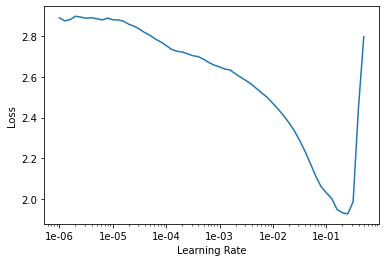

In [249]:
learn.recorder.plot()

In [250]:
learn.fit_one_cycle(5, max_lr=1e-2)

epoch,train_loss,valid_loss,mean_squared_error,time
0,2.313423,1.969781,1.969781,00:46
1,1.770154,0.372062,0.372062,00:45
2,1.135503,0.079978,0.079978,00:44
3,0.784839,0.159184,0.159184,00:45
4,0.575438,0.135379,0.135379,00:44


In [251]:
learn.fit_one_cycle(5, max_lr=1e-2)

epoch,train_loss,valid_loss,mean_squared_error,time
0,0.032971,0.027763,0.027763,00:43
1,0.031939,0.074341,0.074341,00:43
2,0.024982,0.026390,0.026390,00:44
3,0.020691,0.027846,0.027846,00:44
4,0.016680,0.026380,0.026380,00:44


In [256]:
learn.show_results(ds_type=DatasetType.Train)

Bandos%20godsword price 85 days ago,Bandos%20godsword price 48 days ago,Bandos%20godsword price 61 days ago,constant,Bandos%20godsword price 64 days ago,Bandos%20godsword price 90 day rolling average,Bandos%20godsword price 24 days ago,Bandos%20godsword price,Bandos%20godsword price 74 days ago,Bandos%20godsword price 2 days ago,Bandos%20godsword price 73 days ago,Bandos%20godsword price 72 days ago,Bandos%20godsword price delta 21 day rolling average,Bandos%20godsword price 6 days ago,Bandos%20godsword price 63 days ago,Bandos%20godsword price 66 days ago,Bandos%20godsword price 14 days ago,Bandos%20godsword price 80 days ago,Bandos%20godsword price 59 days ago,Bandos%20godsword price delta 7 day rolling average,Bandos%20godsword price 70 days ago,Bandos%20godsword price 25 days ago,Bandos%20godsword price 5 days ago,Bandos%20godsword price 1 days ago,Bandos%20godsword price 27 days ago,Bandos%20godsword price 46 days ago,Bandos%20godsword price 8 days ago,Bandos%20godsword price 81 days ago,Bandos%20godsword price 30 day rolling average,Bandos%20godsword price 40 days ago,Bandos%20godsword price 17 days ago,Bandos%20godsword price delta 90 day rolling average,Bandos%20godsword price 84 days ago,Bandos%20godsword price 76 days ago,Bandos%20godsword price 79 days ago,Bandos%20godsword price 42 days ago,Bandos%20godsword price 30 days ago,Bandos%20godsword price 43 days ago,Bandos%20godsword price 65 days ago,Bandos%20godsword price 20 days ago,Bandos%20godsword price 13 days ago,Bandos%20godsword price 44 days ago,Bandos%20godsword price 83 days ago,Bandos%20godsword price 89 days ago,Bandos%20godsword price 34 days ago,Bandos%20godsword price delta 60 day rolling average,Bandos%20godsword price 0 days ago,Bandos%20godsword price 52 days ago,Bandos%20godsword price 7 days ago,Bandos%20godsword price 45 days ago,Bandos%20godsword price 50 days ago,Bandos%20godsword price 55 days ago,Bandos%20godsword price 39 days ago,Bandos%20godsword price 58 days ago,Bandos%20godsword price 41 days ago,Bandos%20godsword price 53 days ago,Bandos%20godsword price 18 days ago,Bandos%20godsword price 11 days ago,Bandos%20godsword price 60 days ago,Bandos%20godsword price 19 days ago,Bandos%20godsword price 68 days ago,Bandos%20godsword price 21 days ago,Bandos%20godsword price 3 days ago,Bandos%20godsword price 23 days ago,Bandos%20godsword price 10 days ago,Bandos%20godsword price 36 days ago,Bandos%20godsword price 21 day rolling average,Bandos%20godsword price 62 days ago,Bandos%20godsword price 67 days ago,Bandos%20godsword price 31 days ago,Bandos%20godsword price 26 days ago,Bandos%20godsword price 37 days ago,Bandos%20godsword price 82 days ago,Bandos%20godsword price 60 day rolling average,Bandos%20godsword price 35 days ago,Bandos%20godsword price 88 days ago,Bandos%20godsword price 28 days ago,Bandos%20godsword price 29 days ago,Bandos%20godsword price 38 days ago,Bandos%20godsword price 56 days ago,Bandos%20godsword price 12 days ago,Bandos%20godsword price 77 days ago,Bandos%20godsword price 16 days ago,Bandos%20godsword price 87 days ago,Bandos%20godsword price 4 days ago,Bandos%20godsword price 57 days ago,Bandos%20godsword price 49 days ago,Bandos%20godsword price 47 days ago,Bandos%20godsword price 15 days ago,Bandos%20godsword price 71 days ago,Bandos%20godsword price 33 days ago,Bandos%20godsword price delta 30 day rolling average,Bandos%20godsword price 78 days ago,Bandos%20godsword price 7 day rolling average,Bandos%20godsword price delta 3 day rolling average,Bandos%20godsword price 9 days ago,Bandos%20godsword price 32 days ago,Bandos%20godsword price 14 day rolling average,Bandos%20godsword price 86 days ago,Bandos%20godsword price 51 days ago,Bandos%20godsword price 3 day rolling average,Bandos%20godsword price 54 days ago,Bandos%20godsword price delta 14 day rolling average,Bandos%20godsword price 69 days ago,Bandos%20godsword price 75 days ago,Bandos%20godsword price 22 days ago,target,prediction
-0.5093,-1.1752,-0.8682

In [253]:
learn.save('stage-1')

In [203]:
learn = learn.load('stage-1')

In [254]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


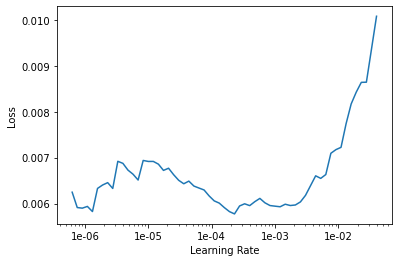

In [255]:
learn.recorder.plot()

In [257]:
learn.fit_one_cycle(5, 3e-5)

epoch,train_loss,valid_loss,mean_squared_error,time
0,0.007463,0.026842,0.026842,00:44
1,0.006506,0.027262,0.027262,00:43
2,0.006016,0.027331,0.027331,00:43
3,0.005407,0.027680,0.027680,00:43
4,0.005342,0.026189,0.026189,00:43


In [258]:
learn.show_results(ds_type=DatasetType.Train)

Bandos%20godsword price 85 days ago,Bandos%20godsword price 48 days ago,Bandos%20godsword price 61 days ago,constant,Bandos%20godsword price 64 days ago,Bandos%20godsword price 90 day rolling average,Bandos%20godsword price 24 days ago,Bandos%20godsword price,Bandos%20godsword price 74 days ago,Bandos%20godsword price 2 days ago,Bandos%20godsword price 73 days ago,Bandos%20godsword price 72 days ago,Bandos%20godsword price delta 21 day rolling average,Bandos%20godsword price 6 days ago,Bandos%20godsword price 63 days ago,Bandos%20godsword price 66 days ago,Bandos%20godsword price 14 days ago,Bandos%20godsword price 80 days ago,Bandos%20godsword price 59 days ago,Bandos%20godsword price delta 7 day rolling average,Bandos%20godsword price 70 days ago,Bandos%20godsword price 25 days ago,Bandos%20godsword price 5 days ago,Bandos%20godsword price 1 days ago,Bandos%20godsword price 27 days ago,Bandos%20godsword price 46 days ago,Bandos%20godsword price 8 days ago,Bandos%20godsword price 81 days ago,Bandos%20godsword price 30 day rolling average,Bandos%20godsword price 40 days ago,Bandos%20godsword price 17 days ago,Bandos%20godsword price delta 90 day rolling average,Bandos%20godsword price 84 days ago,Bandos%20godsword price 76 days ago,Bandos%20godsword price 79 days ago,Bandos%20godsword price 42 days ago,Bandos%20godsword price 30 days ago,Bandos%20godsword price 43 days ago,Bandos%20godsword price 65 days ago,Bandos%20godsword price 20 days ago,Bandos%20godsword price 13 days ago,Bandos%20godsword price 44 days ago,Bandos%20godsword price 83 days ago,Bandos%20godsword price 89 days ago,Bandos%20godsword price 34 days ago,Bandos%20godsword price delta 60 day rolling average,Bandos%20godsword price 0 days ago,Bandos%20godsword price 52 days ago,Bandos%20godsword price 7 days ago,Bandos%20godsword price 45 days ago,Bandos%20godsword price 50 days ago,Bandos%20godsword price 55 days ago,Bandos%20godsword price 39 days ago,Bandos%20godsword price 58 days ago,Bandos%20godsword price 41 days ago,Bandos%20godsword price 53 days ago,Bandos%20godsword price 18 days ago,Bandos%20godsword price 11 days ago,Bandos%20godsword price 60 days ago,Bandos%20godsword price 19 days ago,Bandos%20godsword price 68 days ago,Bandos%20godsword price 21 days ago,Bandos%20godsword price 3 days ago,Bandos%20godsword price 23 days ago,Bandos%20godsword price 10 days ago,Bandos%20godsword price 36 days ago,Bandos%20godsword price 21 day rolling average,Bandos%20godsword price 62 days ago,Bandos%20godsword price 67 days ago,Bandos%20godsword price 31 days ago,Bandos%20godsword price 26 days ago,Bandos%20godsword price 37 days ago,Bandos%20godsword price 82 days ago,Bandos%20godsword price 60 day rolling average,Bandos%20godsword price 35 days ago,Bandos%20godsword price 88 days ago,Bandos%20godsword price 28 days ago,Bandos%20godsword price 29 days ago,Bandos%20godsword price 38 days ago,Bandos%20godsword price 56 days ago,Bandos%20godsword price 12 days ago,Bandos%20godsword price 77 days ago,Bandos%20godsword price 16 days ago,Bandos%20godsword price 87 days ago,Bandos%20godsword price 4 days ago,Bandos%20godsword price 57 days ago,Bandos%20godsword price 49 days ago,Bandos%20godsword price 47 days ago,Bandos%20godsword price 15 days ago,Bandos%20godsword price 71 days ago,Bandos%20godsword price 33 days ago,Bandos%20godsword price delta 30 day rolling average,Bandos%20godsword price 78 days ago,Bandos%20godsword price 7 day rolling average,Bandos%20godsword price delta 3 day rolling average,Bandos%20godsword price 9 days ago,Bandos%20godsword price 32 days ago,Bandos%20godsword price 14 day rolling average,Bandos%20godsword price 86 days ago,Bandos%20godsword price 51 days ago,Bandos%20godsword price 3 day rolling average,Bandos%20godsword price 54 days ago,Bandos%20godsword price delta 14 day rolling average,Bandos%20godsword price 69 days ago,Bandos%20godsword price 75 days ago,Bandos%20godsword price 22 days ago,target,prediction
1.1337,0.5414,1.6283,0.

In [259]:
learn.save('stage-2')

In [260]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


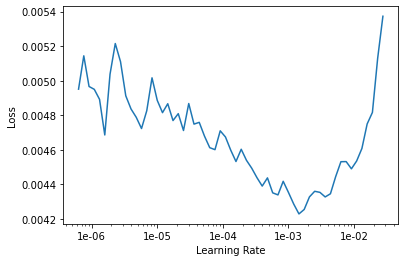

In [261]:
learn.recorder.plot()

In [262]:
learn.fit_one_cycle(5, 3e-6)

epoch,train_loss,valid_loss,mean_squared_error,time
0,0.004762,0.026777,0.026777,00:44
1,0.004674,0.026928,0.026928,00:43
2,0.004583,0.027899,0.027899,00:43
3,0.004398,0.026647,0.026647,00:44
4,0.004137,0.026811,0.026811,00:43


In [263]:
learn.save('stage-3')


In [264]:
learn.show_results(ds_type=DatasetType.Train)

Bandos%20godsword price 85 days ago,Bandos%20godsword price 48 days ago,Bandos%20godsword price 61 days ago,constant,Bandos%20godsword price 64 days ago,Bandos%20godsword price 90 day rolling average,Bandos%20godsword price 24 days ago,Bandos%20godsword price,Bandos%20godsword price 74 days ago,Bandos%20godsword price 2 days ago,Bandos%20godsword price 73 days ago,Bandos%20godsword price 72 days ago,Bandos%20godsword price delta 21 day rolling average,Bandos%20godsword price 6 days ago,Bandos%20godsword price 63 days ago,Bandos%20godsword price 66 days ago,Bandos%20godsword price 14 days ago,Bandos%20godsword price 80 days ago,Bandos%20godsword price 59 days ago,Bandos%20godsword price delta 7 day rolling average,Bandos%20godsword price 70 days ago,Bandos%20godsword price 25 days ago,Bandos%20godsword price 5 days ago,Bandos%20godsword price 1 days ago,Bandos%20godsword price 27 days ago,Bandos%20godsword price 46 days ago,Bandos%20godsword price 8 days ago,Bandos%20godsword price 81 days ago,Bandos%20godsword price 30 day rolling average,Bandos%20godsword price 40 days ago,Bandos%20godsword price 17 days ago,Bandos%20godsword price delta 90 day rolling average,Bandos%20godsword price 84 days ago,Bandos%20godsword price 76 days ago,Bandos%20godsword price 79 days ago,Bandos%20godsword price 42 days ago,Bandos%20godsword price 30 days ago,Bandos%20godsword price 43 days ago,Bandos%20godsword price 65 days ago,Bandos%20godsword price 20 days ago,Bandos%20godsword price 13 days ago,Bandos%20godsword price 44 days ago,Bandos%20godsword price 83 days ago,Bandos%20godsword price 89 days ago,Bandos%20godsword price 34 days ago,Bandos%20godsword price delta 60 day rolling average,Bandos%20godsword price 0 days ago,Bandos%20godsword price 52 days ago,Bandos%20godsword price 7 days ago,Bandos%20godsword price 45 days ago,Bandos%20godsword price 50 days ago,Bandos%20godsword price 55 days ago,Bandos%20godsword price 39 days ago,Bandos%20godsword price 58 days ago,Bandos%20godsword price 41 days ago,Bandos%20godsword price 53 days ago,Bandos%20godsword price 18 days ago,Bandos%20godsword price 11 days ago,Bandos%20godsword price 60 days ago,Bandos%20godsword price 19 days ago,Bandos%20godsword price 68 days ago,Bandos%20godsword price 21 days ago,Bandos%20godsword price 3 days ago,Bandos%20godsword price 23 days ago,Bandos%20godsword price 10 days ago,Bandos%20godsword price 36 days ago,Bandos%20godsword price 21 day rolling average,Bandos%20godsword price 62 days ago,Bandos%20godsword price 67 days ago,Bandos%20godsword price 31 days ago,Bandos%20godsword price 26 days ago,Bandos%20godsword price 37 days ago,Bandos%20godsword price 82 days ago,Bandos%20godsword price 60 day rolling average,Bandos%20godsword price 35 days ago,Bandos%20godsword price 88 days ago,Bandos%20godsword price 28 days ago,Bandos%20godsword price 29 days ago,Bandos%20godsword price 38 days ago,Bandos%20godsword price 56 days ago,Bandos%20godsword price 12 days ago,Bandos%20godsword price 77 days ago,Bandos%20godsword price 16 days ago,Bandos%20godsword price 87 days ago,Bandos%20godsword price 4 days ago,Bandos%20godsword price 57 days ago,Bandos%20godsword price 49 days ago,Bandos%20godsword price 47 days ago,Bandos%20godsword price 15 days ago,Bandos%20godsword price 71 days ago,Bandos%20godsword price 33 days ago,Bandos%20godsword price delta 30 day rolling average,Bandos%20godsword price 78 days ago,Bandos%20godsword price 7 day rolling average,Bandos%20godsword price delta 3 day rolling average,Bandos%20godsword price 9 days ago,Bandos%20godsword price 32 days ago,Bandos%20godsword price 14 day rolling average,Bandos%20godsword price 86 days ago,Bandos%20godsword price 51 days ago,Bandos%20godsword price 3 day rolling average,Bandos%20godsword price 54 days ago,Bandos%20godsword price delta 14 day rolling average,Bandos%20godsword price 69 days ago,Bandos%20godsword price 75 days ago,Bandos%20godsword price 22 days ago,target,prediction
-1.3233,-0.5791,-0.3863

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


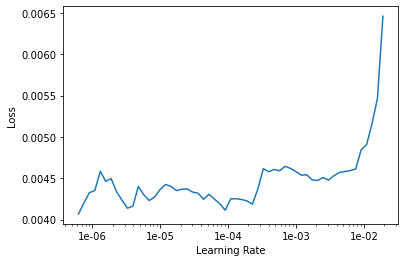

In [266]:
learn.lr_find()
learn.recorder.plot()

In [93]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,mean_squared_error,time
0,80718315126784.000000,75752124973056.000000,75752124973056.000000,00:44
1,80637599940608.000000,75832437506048.000000,75832437506048.000000,00:44
2,80663520739328.000000,76410513260544.000000,76410513260544.000000,00:45
3,80718742945792.000000,76785425317888.000000,76785425317888.000000,00:44
4,80695397449728.000000,75148010979328.000000,75148010979328.000000,00:45


In [188]:
learn.save('stage-4')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


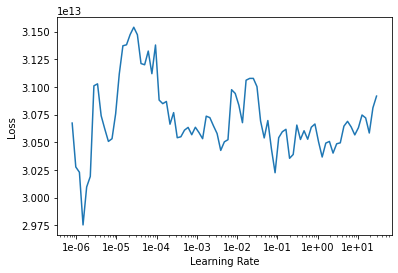

In [189]:
learn.lr_find(end_lr=1e2)
learn.recorder.plot()

In [190]:
learn.show_results(ds_type=DatasetType.Train)

Bandos%20godsword price 66 days ago,Bandos%20godsword price 21 day rolling average,Bandos%20godsword price delta 7 day rolling average,Bandos%20godsword price 19 days ago,Bandos%20godsword price 86 days ago,Bandos%20godsword price 8 days ago,Bandos%20godsword price 40 days ago,Bandos%20godsword price 38 days ago,Bandos%20godsword price 56 days ago,Bandos%20godsword price 65 days ago,Bandos%20godsword price 57 days ago,Bandos%20godsword price 46 days ago,Bandos%20godsword price 3 day rolling average,Bandos%20godsword price 89 days ago,Bandos%20godsword price 4 days ago,Bandos%20godsword price 68 days ago,Bandos%20godsword price 31 days ago,Bandos%20godsword price 79 days ago,Bandos%20godsword price 58 days ago,Bandos%20godsword price 53 days ago,Bandos%20godsword price 70 days ago,Bandos%20godsword price 22 days ago,Bandos%20godsword price 75 days ago,Bandos%20godsword price 63 days ago,Bandos%20godsword price 76 days ago,Bandos%20godsword price 7 days ago,Bandos%20godsword price,Bandos%20godsword price 81 days ago,Bandos%20godsword price delta 60 day rolling average,Bandos%20godsword price 27 days ago,Bandos%20godsword price 52 days ago,Bandos%20godsword price 30 days ago,Bandos%20godsword price 25 days ago,Bandos%20godsword price 61 days ago,Bandos%20godsword price 14 days ago,Bandos%20godsword price 16 days ago,Bandos%20godsword price 87 days ago,Bandos%20godsword price 32 days ago,Bandos%20godsword price delta 21 day rolling average,Bandos%20godsword price delta 3 day rolling average,Bandos%20godsword price 12 days ago,Bandos%20godsword price 51 days ago,Bandos%20godsword price 80 days ago,Bandos%20godsword price 73 days ago,Bandos%20godsword price 59 days ago,Bandos%20godsword price 36 days ago,Bandos%20godsword price 11 days ago,Bandos%20godsword price 84 days ago,Bandos%20godsword price delta 90 day rolling average,Bandos%20godsword price 85 days ago,Bandos%20godsword price 34 days ago,Bandos%20godsword price 49 days ago,Bandos%20godsword price 83 days ago,Bandos%20godsword price 47 days ago,Bandos%20godsword price 88 days ago,Bandos%20godsword price 15 days ago,Bandos%20godsword price 41 days ago,Bandos%20godsword price 28 days ago,Bandos%20godsword price delta 14 day rolling average,Bandos%20godsword price 18 days ago,Bandos%20godsword price delta 30 day rolling average,Bandos%20godsword price 1 days ago,Bandos%20godsword price 37 days ago,Bandos%20godsword price 20 days ago,Bandos%20godsword price 54 days ago,Bandos%20godsword price 69 days ago,Bandos%20godsword price 26 days ago,Bandos%20godsword price 3 days ago,Bandos%20godsword price 72 days ago,Bandos%20godsword price 45 days ago,Bandos%20godsword price 60 days ago,Bandos%20godsword price 50 days ago,Bandos%20godsword price 62 days ago,Bandos%20godsword price 74 days ago,Bandos%20godsword price 21 days ago,Bandos%20godsword price 33 days ago,Bandos%20godsword price 23 days ago,Bandos%20godsword price 9 days ago,Bandos%20godsword price 0 days ago,Bandos%20godsword price 24 days ago,Bandos%20godsword price 10 days ago,Bandos%20godsword price 77 days ago,Bandos%20godsword price 29 days ago,Bandos%20godsword price 2 days ago,Bandos%20godsword price 44 days ago,Bandos%20godsword price 7 day rolling average,Bandos%20godsword price 39 days ago,Bandos%20godsword price 48 days ago,Bandos%20godsword price 42 days ago,Bandos%20godsword price 90 day rolling average,Bandos%20godsword price 5 days ago,Bandos%20godsword price 78 days ago,Bandos%20godsword price 71 days ago,Bandos%20godsword price 13 days ago,Bandos%20godsword price 17 days ago,Bandos%20godsword price 35 days ago,Bandos%20godsword price 64 days ago,Bandos%20godsword price 30 day rolling average,Bandos%20godsword price 82 days ago,Bandos%20godsword price 43 days ago,Bandos%20godsword price 14 day rolling average,Bandos%20godsword price 60 day rolling average,Bandos%20godsword price 6 days ago,Bandos%20godsword price 55 days ago,Bandos%20godsword price 67 days ago,target,prediction
-0.9441,-0.9716,0.4017,-0.9353,-

In [191]:
learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,mean_squared_error,time
0,30444418498560.000000,48036248027136.000000,48036248027136.000000,00:43
1,30363573288960.000000,47287749312512.000000,47287749312512.000000,00:42
2,30467208249344.000000,46848005898240.000000,46848005898240.000000,00:43
3,30621944512512.000000,47671456825344.000000,47671456825344.000000,00:42
4,30727873757184.000000,47893016739840.000000,47893016739840.000000,00:42
5,30574181875712.000000,46909729275904.000000,46909729275904.000000,00:42
6,30659429007360.000000,47402258006016.000000,47402258006016.000000,00:42
7,30709762752512.000000,47150369079296.000000,47150369079296.000000,00:42
8,30697320349696.000000,47321643483136.000000,47321643483136.000000,00:42
9,30597527371776.000000,46393737609216.000000,46393737609216.000000,00:42


In [92]:
learn = learn.load('stage-4')

In [93]:
learn.show_results(ds_type=DatasetType.Train)

Red%20chinchompa price 17 days ago,Red%20chinchompa price 31 days ago,Red%20chinchompa price 58 days ago,Red%20chinchompa price 21 days ago,Red%20chinchompa price 43 days ago,Red%20chinchompa price 40 days ago,Red%20chinchompa price 41 days ago,Red%20chinchompa price 56 days ago,Red%20chinchompa price 77 days ago,Red%20chinchompa price 14 days ago,Red%20chinchompa price 46 days ago,Red%20chinchompa price 69 days ago,Red%20chinchompa price 66 days ago,Red%20chinchompa price 4 days ago,Red%20chinchompa price 44 days ago,Red%20chinchompa price 15 days ago,Red%20chinchompa price 73 days ago,Red%20chinchompa price 70 days ago,Red%20chinchompa price 39 days ago,Red%20chinchompa price 12 days ago,Red%20chinchompa price 72 days ago,Red%20chinchompa price 57 days ago,Red%20chinchompa price 28 days ago,Red%20chinchompa price 51 days ago,Red%20chinchompa price delta 14 day rolling average,Red%20chinchompa price 79 days ago,Red%20chinchompa price 13 days ago,Red%20chinchompa price delta 30 day rolling average,Red%20chinchompa price delta 90 day rolling average,Red%20chinchompa price 48 days ago,Red%20chinchompa price 85 days ago,Red%20chinchompa price 83 days ago,Red%20chinchompa price 0 days ago,Red%20chinchompa price 10 days ago,Red%20chinchompa price 81 days ago,Red%20chinchompa price 22 days ago,Red%20chinchompa price 65 days ago,Red%20chinchompa price 9 days ago,Red%20chinchompa price 80 days ago,Red%20chinchompa price 42 days ago,Red%20chinchompa price 82 days ago,Red%20chinchompa price 7 days ago,Red%20chinchompa price 25 days ago,Red%20chinchompa price 30 days ago,Red%20chinchompa price 30 day rolling average,Red%20chinchompa price 54 days ago,Red%20chinchompa price 63 days ago,Red%20chinchompa price 53 days ago,Red%20chinchompa price 23 days ago,Red%20chinchompa price 1 days ago,Red%20chinchompa price 88 days ago,Red%20chinchompa price 74 days ago,Red%20chinchompa price 14 day rolling average,Red%20chinchompa price 3 days ago,Red%20chinchompa price 11 days ago,Red%20chinchompa price 19 days ago,Red%20chinchompa price 29 days ago,Red%20chinchompa price delta 60 day rolling average,Red%20chinchompa price 24 days ago,Red%20chinchompa price delta 3 day rolling average,Red%20chinchompa price 90 day rolling average,Red%20chinchompa price 45 days ago,Red%20chinchompa price 89 days ago,Red%20chinchompa price 47 days ago,Red%20chinchompa price 8 days ago,Red%20chinchompa price 26 days ago,Red%20chinchompa price 86 days ago,Red%20chinchompa price delta 21 day rolling average,Red%20chinchompa price 75 days ago,Red%20chinchompa price 27 days ago,Red%20chinchompa price,Red%20chinchompa price 60 day rolling average,Red%20chinchompa price 37 days ago,Red%20chinchompa price 52 days ago,Red%20chinchompa price 68 days ago,Red%20chinchompa price 21 day rolling average,Red%20chinchompa price 20 days ago,Red%20chinchompa price 84 days ago,Red%20chinchompa price 59 days ago,Red%20chinchompa price delta 7 day rolling average,Red%20chinchompa price 5 days ago,Red%20chinchompa price 7 day rolling average,Red%20chinchompa price 67 days ago,Red%20chinchompa price 61 days ago,Red%20chinchompa price 71 days ago,Red%20chinchompa price 35 days ago,Red%20chinchompa price 34 days ago,Red%20chinchompa price 78 days ago,Red%20chinchompa price 3 day rolling average,Red%20chinchompa price 18 days ago,Red%20chinchompa price 33 days ago,Red%20chinchompa price 49 days ago,Red%20chinchompa price 2 days ago,Red%20chinchompa price 6 days ago,Red%20chinchompa price 50 days ago,Red%20chinchompa price 38 days ago,Red%20chinchompa price 32 days ago,Red%20chinchompa price 55 days ago,Red%20chinchompa price 76 days ago,Red%20chinchompa price 60 days ago,Red%20chinchompa price 16 days ago,Red%20chinchompa price 87 days ago,Red%20chinchompa price 36 days ago,Red%20chinchompa price 64 days ago,Red%20chinchompa price 62 days ago,target,prediction
-0.6541,-0.3319,-1.1115,-0.6113,-0.6339,-0.7432,-0.7069,-1.1855,-1.2912,-0.6024,-0.7256,-1.1760,-0.6523,-0.1291,-0.5457,-0.6854,-1.0977,-

# Plot results

In [267]:
int(learn.predict(df.iloc[0])[1])

1

In [268]:
learn.predict(df.iloc[0])

(FloatItem [1.692582], tensor([1.6926]), tensor([1.6926]))

In [285]:
plot_x = [float(learn.predict(df.iloc[i])[1]) for i in range(len(df))]

In [286]:
plot_y = df['Y']

In [287]:
plot_y

date_obj
2018-05-02    1.839836
2018-05-03    1.771420
2018-05-04    1.703742
2018-05-05    1.749774
2018-05-06    1.745821
                ...   
2020-05-02    1.960459
2020-05-03    1.958383
2020-05-04    1.950933
2020-05-05    1.947396
2020-05-06    1.939891
Name: Y, Length: 731, dtype: float64

In [288]:
plot_x

[1.6925820112228394,
 1.6728895902633667,
 1.676784873008728,
 1.6865955591201782,
 1.6946760416030884,
 1.7111082077026367,
 1.725579857826233,
 1.7476301193237305,
 1.7738926410675049,
 1.787095546722412,
 1.8288915157318115,
 1.8314381837844849,
 1.81984543800354,
 1.8105864524841309,
 1.770220160484314,
 1.7512602806091309,
 1.7643382549285889,
 1.7685394287109375,
 1.7593156099319458,
 1.7543110847473145,
 1.760448694229126,
 1.7546840906143188,
 1.7698357105255127,
 1.7863044738769531,
 1.8267563581466675,
 1.843147873878479,
 1.8421144485473633,
 1.8366432189941406,
 1.8143527507781982,
 1.7992618083953857,
 1.7809271812438965,
 1.7797354459762573,
 1.7929513454437256,
 1.7949767112731934,
 1.787532925605774,
 1.803849220275879,
 1.8252451419830322,
 1.7788084745407104,
 1.7847445011138916,
 1.8260886669158936,
 1.8255257606506348,
 1.8363525867462158,
 1.8030238151550293,
 1.7747491598129272,
 1.7630583047866821,
 1.773074984550476,
 1.7518553733825684,
 1.7367273569107056,
 1.

In [289]:
plot_df = pd.DataFrame(plot_y)

In [290]:
plot_df['x'] = plot_x

In [291]:
plot_df.head()

,Y,x
date_obj,,
2018-05-02,1.839836,1.692582
2018-05-03,1.771420,1.672890
2018-05-04,1.703742,1.676785
2018-05-05,1.749774,1.686596
2018-05-06,1.745821,1.694676


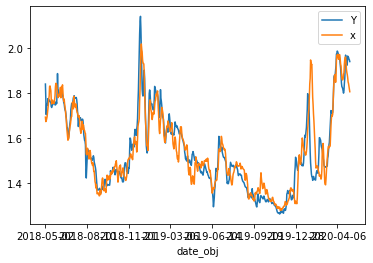

In [292]:
plot_df.plot()

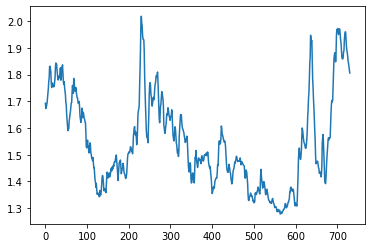

In [293]:
plt.plot(plot_x)

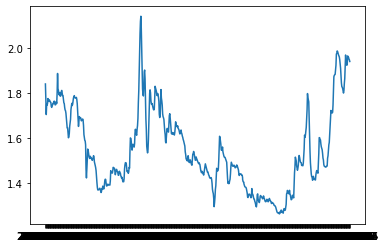

In [294]:
plt.plot(plot_y)

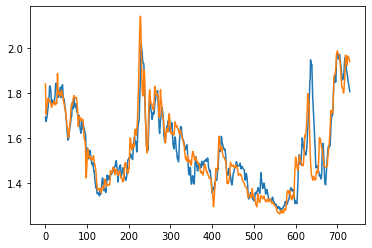

In [295]:
plt.plot(range(len(plot_x)),np.array([plot_x,plot_y]).T)

In [296]:
len(plot_x)

731

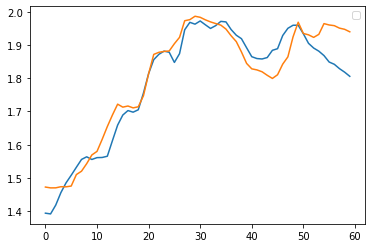

In [297]:
plt.plot(range(len(plot_x[len(plot_x)-60:])), np.array([plot_x[len(plot_x)-60:], plot_y[len(plot_y)-60:]]).T)
plt.legend()

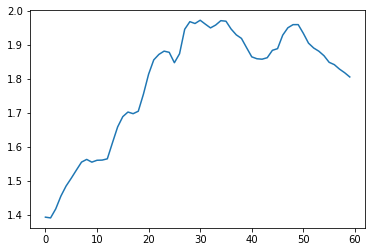

In [298]:
plt.plot(plot_x[len(plot_x)-60:])

In [299]:
len(plot_x)

731

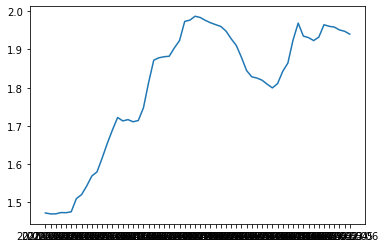

In [300]:
plt.plot(plot_y[len(plot_y)-60:])

In [301]:
x_series = pd.Series(plot_x, name='Predict')

In [302]:
type(x_series)

pandas.core.series.Series

In [303]:
type(plot_y)

pandas.core.series.Series

In [304]:
y_series = plot_y.reindex(x_series.index)

ValueError: cannot reindex from a duplicate axis

In [305]:
y_series

NameError: name 'y_series' is not defined

In [306]:
x_series

0      1.692582
1      1.672890
2      1.676785
3      1.686596
4      1.694676
         ...   
726    1.848884
727    1.842039
728    1.828954
729    1.818365
730    1.805793
Name: Predict, Length: 731, dtype: float64

In [307]:
pd.concat([y_series, x_series],  axis=1).iloc[1705-60:].plot()

NameError: name 'y_series' is not defined

In [ ]:
learn.drop

In [308]:
learn.save('stage-final')
learn.export()

# Load in the full data (recent rows will have been dropped because Ys were N/A)

In [309]:
prediction_df = item_df_training

In [375]:
prediction_df['constant'] = time_trimmed_df['Y'].mean() *scaling_factor

In [376]:
prediction_df.columns

Index(['Bandos%20godsword price', 'Bandos%20godsword price 0 days ago',
       'Bandos%20godsword price 1 days ago',
       'Bandos%20godsword price 2 days ago',
       'Bandos%20godsword price 3 days ago',
       'Bandos%20godsword price 4 days ago',
       'Bandos%20godsword price 5 days ago',
       'Bandos%20godsword price 6 days ago',
       'Bandos%20godsword price 7 days ago',
       'Bandos%20godsword price 8 days ago',
       ...
       'Bandos%20godsword price delta 3 day rolling average',
       'Bandos%20godsword price delta 7 day rolling average',
       'Bandos%20godsword price delta 14 day rolling average',
       'Bandos%20godsword price delta 21 day rolling average',
       'Bandos%20godsword price delta 30 day rolling average',
       'Bandos%20godsword price delta 60 day rolling average',
       'Bandos%20godsword price delta 90 day rolling average', 'Y', 'constant',
       'predictions'],
      dtype='object', length=108)

In [377]:
prediction_df = prediction_df.fillna(method='ffill').fillna(method='bfill').fillna(0)

In [378]:
predict_data = TabularDataBunch.from_df(path, prediction_df, dep_var, valid_idx=valid_idx, procs=procs, cat_names=[])

In [379]:
predict_learn = tabular_learner(data, layers=[500,100], emb_szs={'native-country': 10}, metrics=mean_squared_error)

In [380]:
predict_learn =predict_learn.load('stage-final')

In [381]:
predict_learn.show_results(ds_type=DatasetType.Train)

Bandos%20godsword price 85 days ago,Bandos%20godsword price 48 days ago,Bandos%20godsword price 61 days ago,constant,Bandos%20godsword price 64 days ago,Bandos%20godsword price 90 day rolling average,Bandos%20godsword price 24 days ago,Bandos%20godsword price,Bandos%20godsword price 74 days ago,Bandos%20godsword price 2 days ago,Bandos%20godsword price 73 days ago,Bandos%20godsword price 72 days ago,Bandos%20godsword price delta 21 day rolling average,Bandos%20godsword price 6 days ago,Bandos%20godsword price 63 days ago,Bandos%20godsword price 66 days ago,Bandos%20godsword price 14 days ago,Bandos%20godsword price 80 days ago,Bandos%20godsword price 59 days ago,Bandos%20godsword price delta 7 day rolling average,Bandos%20godsword price 70 days ago,Bandos%20godsword price 25 days ago,Bandos%20godsword price 5 days ago,Bandos%20godsword price 1 days ago,Bandos%20godsword price 27 days ago,Bandos%20godsword price 46 days ago,Bandos%20godsword price 8 days ago,Bandos%20godsword price 81 days ago,Bandos%20godsword price 30 day rolling average,Bandos%20godsword price 40 days ago,Bandos%20godsword price 17 days ago,Bandos%20godsword price delta 90 day rolling average,Bandos%20godsword price 84 days ago,Bandos%20godsword price 76 days ago,Bandos%20godsword price 79 days ago,Bandos%20godsword price 42 days ago,Bandos%20godsword price 30 days ago,Bandos%20godsword price 43 days ago,Bandos%20godsword price 65 days ago,Bandos%20godsword price 20 days ago,Bandos%20godsword price 13 days ago,Bandos%20godsword price 44 days ago,Bandos%20godsword price 83 days ago,Bandos%20godsword price 89 days ago,Bandos%20godsword price 34 days ago,Bandos%20godsword price delta 60 day rolling average,Bandos%20godsword price 0 days ago,Bandos%20godsword price 52 days ago,Bandos%20godsword price 7 days ago,Bandos%20godsword price 45 days ago,Bandos%20godsword price 50 days ago,Bandos%20godsword price 55 days ago,Bandos%20godsword price 39 days ago,Bandos%20godsword price 58 days ago,Bandos%20godsword price 41 days ago,Bandos%20godsword price 53 days ago,Bandos%20godsword price 18 days ago,Bandos%20godsword price 11 days ago,Bandos%20godsword price 60 days ago,Bandos%20godsword price 19 days ago,Bandos%20godsword price 68 days ago,Bandos%20godsword price 21 days ago,Bandos%20godsword price 3 days ago,Bandos%20godsword price 23 days ago,Bandos%20godsword price 10 days ago,Bandos%20godsword price 36 days ago,Bandos%20godsword price 21 day rolling average,Bandos%20godsword price 62 days ago,Bandos%20godsword price 67 days ago,Bandos%20godsword price 31 days ago,Bandos%20godsword price 26 days ago,Bandos%20godsword price 37 days ago,Bandos%20godsword price 82 days ago,Bandos%20godsword price 60 day rolling average,Bandos%20godsword price 35 days ago,Bandos%20godsword price 88 days ago,Bandos%20godsword price 28 days ago,Bandos%20godsword price 29 days ago,Bandos%20godsword price 38 days ago,Bandos%20godsword price 56 days ago,Bandos%20godsword price 12 days ago,Bandos%20godsword price 77 days ago,Bandos%20godsword price 16 days ago,Bandos%20godsword price 87 days ago,Bandos%20godsword price 4 days ago,Bandos%20godsword price 57 days ago,Bandos%20godsword price 49 days ago,Bandos%20godsword price 47 days ago,Bandos%20godsword price 15 days ago,Bandos%20godsword price 71 days ago,Bandos%20godsword price 33 days ago,Bandos%20godsword price delta 30 day rolling average,Bandos%20godsword price 78 days ago,Bandos%20godsword price 7 day rolling average,Bandos%20godsword price delta 3 day rolling average,Bandos%20godsword price 9 days ago,Bandos%20godsword price 32 days ago,Bandos%20godsword price 14 day rolling average,Bandos%20godsword price 86 days ago,Bandos%20godsword price 51 days ago,Bandos%20godsword price 3 day rolling average,Bandos%20godsword price 54 days ago,Bandos%20godsword price delta 14 day rolling average,Bandos%20godsword price 69 days ago,Bandos%20godsword price 75 days ago,Bandos%20godsword price 22 days ago,target,prediction
-0.5180,-0.1260,0.4325,

In [382]:
predict_learn.predict(prediction_df.iloc[0])

(FloatItem [1.335256e+11], tensor([1.3353e+11]), tensor([1.3353e+11]))

In [384]:
predict_learn.predict(prediction_df.iloc[100])

(FloatItem [1.335256e+11], tensor([1.3353e+11]), tensor([1.3353e+11]))

In [387]:
prediction_df

,Bandos%20godsword price,Bandos%20godsword price 0 days ago,Bandos%20godsword price 1 days ago,Bandos%20godsword price 2 days ago,Bandos%20godsword price 3 days ago,Bandos%20godsword price 4 days ago,Bandos%20godsword price 5 days ago,Bandos%20godsword price 6 days ago,Bandos%20godsword price 7 days ago,Bandos%20godsword price 8 days ago,...,Bandos%20godsword price delta 3 day rolling average,Bandos%20godsword price delta 7 day rolling average,Bandos%20godsword price delta 14 day rolling average,Bandos%20godsword price delta 21 day rolling average,Bandos%20godsword price delta 30 day rolling average,Bandos%20godsword price delta 60 day rolling average,Bandos%20godsword price delta 90 day rolling average,Y,constant,predictions
date_obj,,,,,,,,,,,,,,,,,,,,,
2015-03-26,3188120,3188120,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,...,-22986.000000,-56560.000000,-39271.285714,335533.428571,1.797892e+06,2.874354e+05,9.104104e+04,0.458172,1.046340e+07,1.335256e+11
2015-03-27,3188120,3188120,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,...,-22986.000000,-56560.000000,-39271.285714,335533.428571,1.797892e+06,2.874354e+05,9.104104e+04,0.458150,1.046340e+07,1.335256e+11
2015-03-28,3153641,3153641,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,...,-22986.000000,-56560.000000,-39271.285714,335533.428571,1.797892e+06,2.874354e+05,9.104104e+04,0.461537,1.046340e+07,1.335256e+11
2015-03-29,3168120,3168120,3153641.0,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,...,-1840.333333,-56560.000000,-39271.285714,335533.428571,1.797892e+06,2.874354e+05,9.104104e+04,0.463653,1.046340e+07,1.335256e+11
2015-03-30,3145239,3145239,3168120.0,3153641.0,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,...,-10427.666667,-56560.000000,-39271.285714,335533.428571,1.797892e+06,2.874354e+05,9.104104e+04,0.460632,1.046340e+07,1.335256e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-09,13245757,13245757,13273304.0,13054803.0,12993210.0,13045429.0,13072641.0,13301814.0,13002689.0,12596802.0,...,54469.000000,104763.000000,464220.642857,489470.190476,3.269809e+05,1.268631e+06,1.924239e+06,1.939891,1.046340e+07,1.335256e+11
2020-05-10,13231731,13231731,13245757.0,13273304.0,13054803.0,12993210.0,13045429.0,13072641.0,13301814.0,13002689.0,...,-18533.000000,100748.857143,383174.785714,472138.523810,3.050321e+05,1.203210e+06,1.873210e+06,1.939891,1.046340e+07,1.335256e+11
2020-05-11,13181398,13181398,13231731.0,13245757.0,13273304.0,13054803.0,12993210.0,13045429.0,13072641.0,13301814.0,...,-38230.666667,34879.142857,264292.714286,414393.476190,2.597132e+05,1.099913e+06,1.784488e+06,1.939891,1.046340e+07,1.335256e+11


In [388]:
predictions = [float(predict_learn.predict(prediction_df.iloc[i])[1]) for i in range(len(prediction_df))]


In [389]:
predictions

[133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.0,
 133525585920.

In [390]:
prediction_df.tail()

,Bandos%20godsword price,Bandos%20godsword price 0 days ago,Bandos%20godsword price 1 days ago,Bandos%20godsword price 2 days ago,Bandos%20godsword price 3 days ago,Bandos%20godsword price 4 days ago,Bandos%20godsword price 5 days ago,Bandos%20godsword price 6 days ago,Bandos%20godsword price 7 days ago,Bandos%20godsword price 8 days ago,...,Bandos%20godsword price delta 3 day rolling average,Bandos%20godsword price delta 7 day rolling average,Bandos%20godsword price delta 14 day rolling average,Bandos%20godsword price delta 21 day rolling average,Bandos%20godsword price delta 30 day rolling average,Bandos%20godsword price delta 60 day rolling average,Bandos%20godsword price delta 90 day rolling average,Y,constant,predictions
date_obj,,,,,,,,,,,,,,,,,,,,,
2020-05-09,13245757,13245757,13273304.0,13054803.0,12993210.0,13045429.0,13072641.0,13301814.0,13002689.0,12596802.0,...,54469.000000,104763.000000,464220.642857,489470.190476,326980.866667,1.268631e+06,1.924239e+06,1.939891,1.046340e+07,1.335256e+11
2020-05-10,13231731,13231731,13245757.0,13273304.0,13054803.0,12993210.0,13045429.0,13072641.0,13301814.0,13002689.0,...,-18533.000000,100748.857143,383174.785714,472138.523810,305032.066667,1.203210e+06,1.873210e+06,1.939891,1.046340e+07,1.335256e+11
2020-05-11,13181398,13181398,13231731.0,13245757.0,13273304.0,13054803.0,12993210.0,13045429.0,13072641.0,13301814.0,...,-38230.666667,34879.142857,264292.714286,414393.476190,259713.233333,1.099913e+06,1.784488e+06,1.939891,1.046340e+07,1.335256e+11
2020-05-12,13157501,13157501,13181398.0,13231731.0,13245757.0,13273304.0,13054803.0,12993210.0,13045429.0,13072641.0,...,-32709.000000,-5028.142857,168997.857143,378577.523810,242371.933333,1.022749e+06,1.721573e+06,1.939891,1.046340e+07,1.335256e+11
2020-05-13,13106793,13106793,13157501.0,13181398.0,13231731.0,13245757.0,13273304.0,13054803.0,12993210.0,13045429.0,...,-41771.000000,-71962.285714,55877.285714,308355.952381,202212.933333,9.194226e+05,1.632241e+06,1.939891,1.046340e+07,1.335256e+11


In [391]:
prediction_df['predictions'] = predictions

In [392]:
prediction_df['predictions'].tail(30)

date_obj
2020-04-14    1.335256e+11
2020-04-15    1.335256e+11
2020-04-16    1.335256e+11
2020-04-17    1.335256e+11
2020-04-18    1.335256e+11
2020-04-19    1.335256e+11
2020-04-20    1.335256e+11
2020-04-21    1.335256e+11
2020-04-22    1.335256e+11
2020-04-23    1.335256e+11
2020-04-24    1.335256e+11
2020-04-25    1.335256e+11
2020-04-26    1.335256e+11
2020-04-27    1.335256e+11
2020-04-28    1.335256e+11
2020-04-29    1.335256e+11
2020-04-30    1.335256e+11
2020-05-01    1.335256e+11
2020-05-02    1.335256e+11
2020-05-03    1.335256e+11
2020-05-04    1.335256e+11
2020-05-05    1.335256e+11
2020-05-06    1.335256e+11
2020-05-07    1.335256e+11
2020-05-08    1.335256e+11
2020-05-09    1.335256e+11
2020-05-10    1.335256e+11
2020-05-11    1.335256e+11
2020-05-12    1.335256e+11
2020-05-13    1.335256e+11
Name: predictions, dtype: float64

In [393]:
prediction_df

,Bandos%20godsword price,Bandos%20godsword price 0 days ago,Bandos%20godsword price 1 days ago,Bandos%20godsword price 2 days ago,Bandos%20godsword price 3 days ago,Bandos%20godsword price 4 days ago,Bandos%20godsword price 5 days ago,Bandos%20godsword price 6 days ago,Bandos%20godsword price 7 days ago,Bandos%20godsword price 8 days ago,...,Bandos%20godsword price delta 3 day rolling average,Bandos%20godsword price delta 7 day rolling average,Bandos%20godsword price delta 14 day rolling average,Bandos%20godsword price delta 21 day rolling average,Bandos%20godsword price delta 30 day rolling average,Bandos%20godsword price delta 60 day rolling average,Bandos%20godsword price delta 90 day rolling average,Y,constant,predictions
date_obj,,,,,,,,,,,,,,,,,,,,,
2015-03-26,3188120,3188120,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,...,-22986.000000,-56560.000000,-39271.285714,335533.428571,1.797892e+06,2.874354e+05,9.104104e+04,0.458172,1.046340e+07,1.335256e+11
2015-03-27,3188120,3188120,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,...,-22986.000000,-56560.000000,-39271.285714,335533.428571,1.797892e+06,2.874354e+05,9.104104e+04,0.458150,1.046340e+07,1.335256e+11
2015-03-28,3153641,3153641,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,...,-22986.000000,-56560.000000,-39271.285714,335533.428571,1.797892e+06,2.874354e+05,9.104104e+04,0.461537,1.046340e+07,1.335256e+11
2015-03-29,3168120,3168120,3153641.0,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,...,-1840.333333,-56560.000000,-39271.285714,335533.428571,1.797892e+06,2.874354e+05,9.104104e+04,0.463653,1.046340e+07,1.335256e+11
2015-03-30,3145239,3145239,3168120.0,3153641.0,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,3188120.0,...,-10427.666667,-56560.000000,-39271.285714,335533.428571,1.797892e+06,2.874354e+05,9.104104e+04,0.460632,1.046340e+07,1.335256e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-09,13245757,13245757,13273304.0,13054803.0,12993210.0,13045429.0,13072641.0,13301814.0,13002689.0,12596802.0,...,54469.000000,104763.000000,464220.642857,489470.190476,3.269809e+05,1.268631e+06,1.924239e+06,1.939891,1.046340e+07,1.335256e+11
2020-05-10,13231731,13231731,13245757.0,13273304.0,13054803.0,12993210.0,13045429.0,13072641.0,13301814.0,13002689.0,...,-18533.000000,100748.857143,383174.785714,472138.523810,3.050321e+05,1.203210e+06,1.873210e+06,1.939891,1.046340e+07,1.335256e+11
2020-05-11,13181398,13181398,13231731.0,13245757.0,13273304.0,13054803.0,12993210.0,13045429.0,13072641.0,13301814.0,...,-38230.666667,34879.142857,264292.714286,414393.476190,2.597132e+05,1.099913e+06,1.784488e+06,1.939891,1.046340e+07,1.335256e+11


#### 